In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from scipy.stats import norm, probplot
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split

We want to perform PCR on the congressional district dataset.  The dataset consists of 45 numerical columns that we will use as features and the target variable will be dem_pct, which describes how much of the total vote was won by the Democratic Party in a particular congressional district from the 2014, 2016, and 2018 US Congressional Elections.  The purpose of performing PCR on this dataset is to check, using the principal components as features, if there is a linear relationship between the percent that a congressional district voted for the Democratic Party and determine which features were most important in that prediction. 

In [75]:
#Import dataset
data = pd.read_csv('cap_final.csv')
data.head(5)

,Unnamed: 0,party,abbreviation,state_dist,year,district,state,pct_won,laborforce_unemployed,PercentCar,...,r25k_50k,r50k_100k,r100k_200k,r200kplus,NoHighSchool,HighSchoolEd,SomeCollege,BachelorsOrHigher,dem_pct,rep_pct
0,1,R,AL,AL-1,2014,1,Alabama,68.16,4.7,87.3,...,25.8,28.1,13.8,2.5,13.5,32.7,30.7,23.1,31.84,68.16
1,2,R,AL,AL-2,2014,2,Alabama,67.34,5.2,85.1,...,27.3,27.6,12.8,2.0,16.4,32.4,29.5,21.6,32.66,67.34
2,3,R,AL,AL-3,2014,3,Alabama,66.12,5.2,86.3,...,27.1,27.2,12.2,2.0,16.6,33.0,30.1,20.4,33.88,66.12
3,4,R,AL,AL-4,2014,4,Alabama,98.57,4.1,86.1,...,26.8,27.7,10.5,1.5,19.3,35.1,29.3,16.3,1.43,98.57
4,5,R,AL,AL-5,2014,5,Alabama,74.42,4.6,87.2,...,24.9,27.8,17.7,3.8,14.0,26.6,29.9,29.5,25.58,74.42


Because the rows where a candidate won by default due to having nobody run against them skews the distribution of dem_pct and don't necessarily reflect how much of the percentage of voting a candidate expects to receive if someone ran against them, we will drop these rows and run the regression without them.

In [76]:
#data.loc[data['rep_pct'] == 0]
#data.loc[data['dem_pct'] == 0]
#Drop rows where dem_pct or rep_pct equals 0
data = data.drop(data.index[[272, 274, 285, 287, 311, 324, 344, 328, 332, 340, 346, 352, 
                             354, 355, 368, 364, 369, 372, 373, 428, 417, 985, 986, 989, 
                             508, 511, 704, 879, 900, 942, 947, 992, 1002, 
                             1007, 1086, 1121, 1015]])


In [77]:
#Set X and y values 
X = data.loc[:,'laborforce_unemployed':'BachelorsOrHigher'] 
y = data['dem_pct']

In [78]:
data.shape

(1268, 55)

We first want to check the distribution of the target variable 'dem_pct' and see if it meets all the assumptions of a valid multiple linear regression: linear relationship between target and features, residuals are normally distributed, no multicollinearity, and the variance of the errors is constant.

mu = 51.32, sigma = 18.15


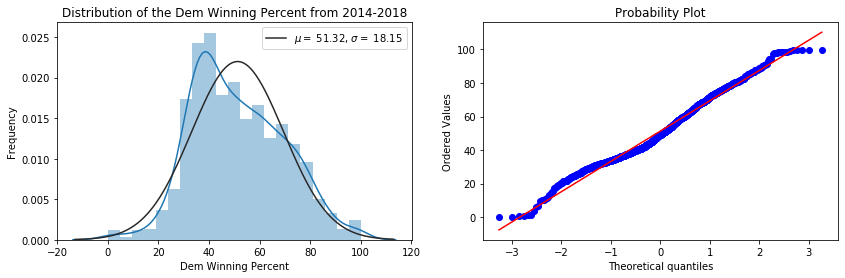

In [79]:
#Check distribution of dem_pct and QQ plot 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 4))
sns.distplot(y, fit=norm, ax = ax1)

#Find mean and standard deviation
(mu, sigma) = norm.fit(y)
print('mu = {:.2f}, sigma = {:.2f}'.format(mu, sigma))

#Set labels and legend 
ax1.legend(['$\mu=$ {:.2f}, $\sigma=$ {:.2f}'.format(mu, sigma)],loc='best')
ax1.set_xlabel('Dem Winning Percent')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of the Dem Winning Percent from 2014-2018')

#QQ plot
ax2 = plt.subplot(122)
res = probplot(y, plot=plt)

Before proceeding to modeling, we can get a sense of which features might be important later in the regression model by calculating the correlation with dem_pct and checking which are highest.

In [80]:
data_corr = data.loc[:,'laborforce_unemployed':'dem_pct'].corr()
np.fill_diagonal(data_corr.values, -2)   #Fill diagonals with -2 to get rid of self-correlation
top_10_all = data_corr['dem_pct'].abs().nlargest(11)
top_10_corr = top_10_all[1:12]
top_10_corr

white_pct                0.619407
foreign_born             0.522526
PercentCar               0.510191
vet_percent              0.506411
ForeignNotCit            0.500339
ForeignCit               0.495228
Pct20t45                 0.489589
home_lang_not_english    0.486944
PercentPublicTrans       0.464864
Other_means              0.398995
Name: dem_pct, dtype: float64

In [81]:
#Create dataframe with dem_pct correlations and column names
dem_pct = list(data_corr['dem_pct'])
cols = list(data_corr.columns)
corr_df = pd.DataFrame(
    {'dem_pct': dem_pct,
     'cols': cols,
    })
corr_df = corr_df.drop(corr_df.index[45])

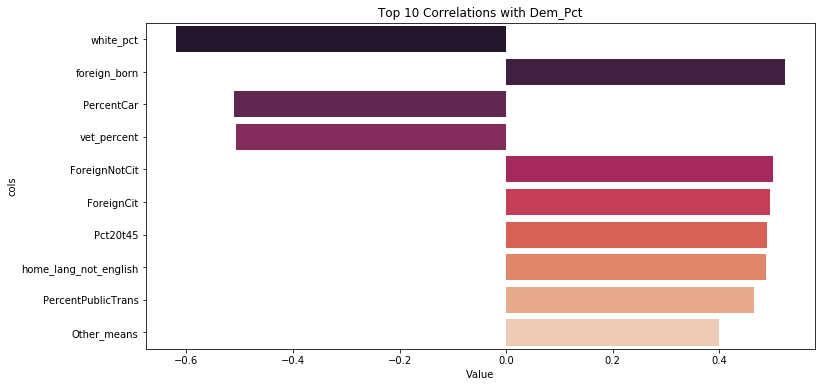

In [82]:
#Plot top 10 features in first principal component
corr_df['abs_corr']=corr_df['dem_pct'].apply(lambda x: np.abs(x))
ax = sns.barplot(x='dem_pct', y='cols', palette="rocket", data=corr_df.sort_values('abs_corr', ascending=False).head(10))
ax.set_xlabel('Value')
ax.set_title('Top 10 Correlations with Dem_Pct')
plt.show()

We see that the percentage of white residents and percentage of residents who drive to work have the largest negative correlations with dem_pct, while the percentage of foreign born residents, younger residents, and people who live in cities seems to play a large role. This seems consistent with the idea that heavily Republican districts are often suburban or rural and heavily Democrat districts often have a large foreign population and tend to be more urban.

We can now scale our features and check how many principal components we should use by looking at the decrease in MSE.  

In [83]:
#Define the PCA object
pca = PCA()

#Scale the features by subtracting the mean and setting variance equal to 1
X_reduced = pca.fit_transform(scale(X))

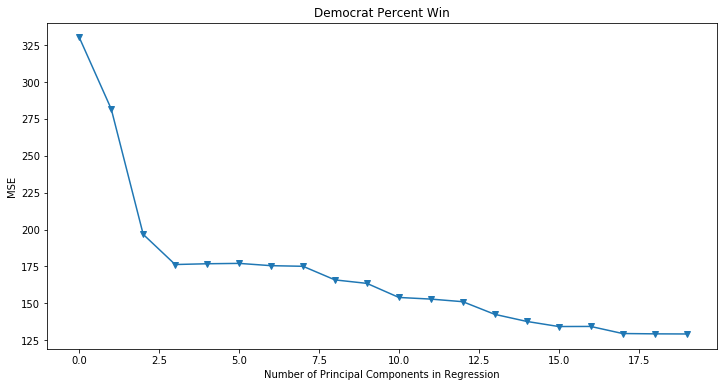

In [84]:
#10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = KFold( n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []

#Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

#Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
#Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of Principal Components in Regression')
plt.ylabel('MSE')
plt.title('Democrat Percent Win')
plt.xlim(xmin=-1);

In [85]:
#How much did each additional component increase percent of explained variance 
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 26.22,  46.56,  57.32,  64.57,  69.86,  74.29,  78.05,  80.87,
        83.39,  85.73,  87.64,  89.12,  90.41,  91.56,  92.63,  93.6 ,
        94.41,  95.07,  95.64,  96.17,  96.68,  97.13,  97.55,  97.92,
        98.26,  98.58,  98.85,  99.09,  99.28,  99.43,  99.57,  99.67,
        99.76,  99.84,  99.89,  99.92,  99.95,  99.97,  99.99, 100.  ,
       100.01, 100.01, 100.01, 100.01, 100.01])

We can visualize the explained variance ratio by checking to see where it crosses the 95% threshold. 

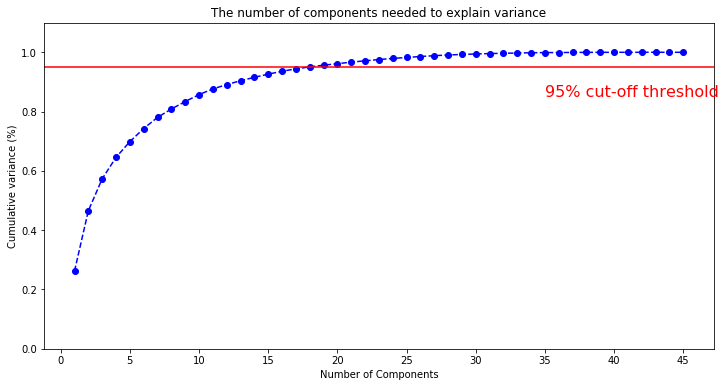

In [86]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 46, step=1)
tot_exp_var = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, tot_exp_var, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 46, step=5)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(35, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

#ax.grid(axis='x')
plt.show()

It appears based off the above results that 18 principal components explain 95% of the variance in our dataset.  We will keep 18 and use them on the training set and evaluate their test set performance.

In [87]:
# Split into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Scale the data
X_reduced_train = pca.fit_transform(scale(X_train))
n = len(X_reduced_train)

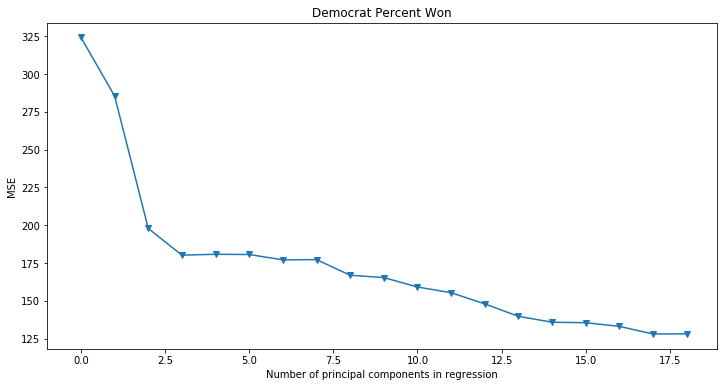

In [88]:
# 10-fold CV, with shuffle
kf_10 = KFold( n_splits=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 18 principle components, adding one component at the time.
for i in np.arange(1, 19):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Democrat Percent Won')
plt.xlim(xmin=-1);

In [89]:
X_reduced_test = pca.transform(scale(X_test))[:,:18]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train[:,:18], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

134.08666790279173

In [90]:
def pcr(X,y,pc):

    
    # Create linear regression object
    regr = LinearRegression()

    # Fit
    regr.fit(X, y)

    # Calibration
    y_c = regr.predict(X)

    # Cross-validation
    y_cv = cross_val_predict(regr, X, y, cv=10)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    return(y_cv, score_c, score_cv, mse_c, mse_cv)

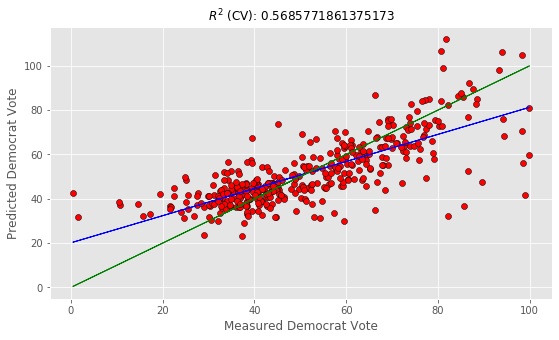

In [91]:
predicted, r2r, r2cv, mser, mscv = pcr(X_reduced_test, y_test, pc=18)

# Regression plot
z = np.polyfit(y_test, predicted, 1)

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y_test, predicted, c='red', edgecolors='k')
    ax.plot(y_test, z[1]+z[0]*y_test, c='blue', linewidth=1)
    ax.plot(y_test, y_test, color='green', linewidth=1)

plt.title('$R^{2}$ (CV): '+str(r2cv))
plt.xlabel('Measured Democrat Vote')
plt.ylabel('Predicted Democrat Vote')
plt.show()

To understand which principal components are contributing the most to our explained variance, we can plot the composition of the first and second principal components since these will explain a large portion of the variance.

In [92]:
#Create a dataframe for the first, second, and third principal components
pca0 = list(pca.components_[0])
cols = list(X.columns)
pca_df0 = pd.DataFrame(
    {'pca0': pca0,
     'cols': cols,
    })

pca1 = list(pca.components_[1])
pca_df1 = pd.DataFrame(
    {'pca1': pca1,
     'cols': cols,
    })

pca2 = list(pca.components_[2])
pca_df2 = pd.DataFrame(
    {'pca2': pca2,
     'cols': cols,
    })

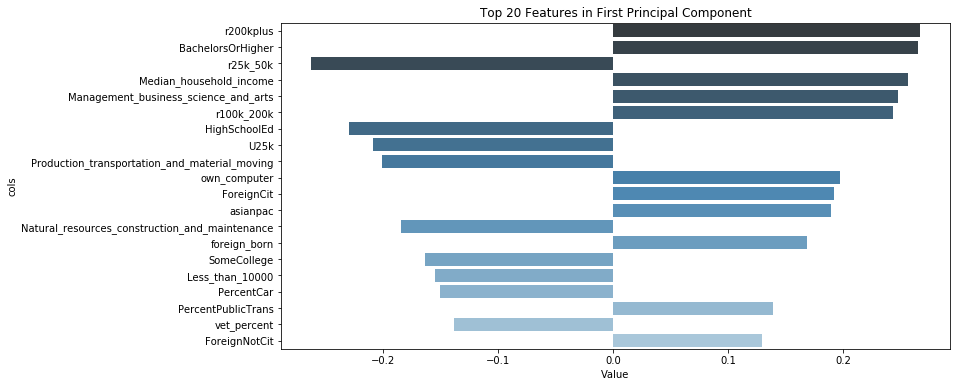

In [93]:
#Top 20 Features in First Principal Component
pca_df0['abs_pca0']=pca_df0['pca0'].apply(lambda x: np.abs(x))
ax = sns.barplot(x='pca0', y='cols', palette="Blues_d", data=pca_df0.sort_values('abs_pca0', ascending=False).head(20))
ax.set_xlabel('Value')
ax.set_title('Top 20 Features in First Principal Component')
plt.show()

To check and see how a smaller model with better predictors may have done, we can select the top 10 features based upon the correlation plots and perform PCA on them and fit them in a regression model.

In [266]:
#Set X and y values
X2 = data[['white_pct','foreign_born', 'PercentCar', 'vet_percent', 'ForeignNotCit', 'home_lang_not_english',
                 'PercentPublicTrans', 'Other_means']]
               
y2 = data['dem_pct']

In [267]:
# Split into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=1)

# Scale the data
X_reduced_train2 = pca.fit_transform(scale(X_train))
n = len(X_reduced_train2)

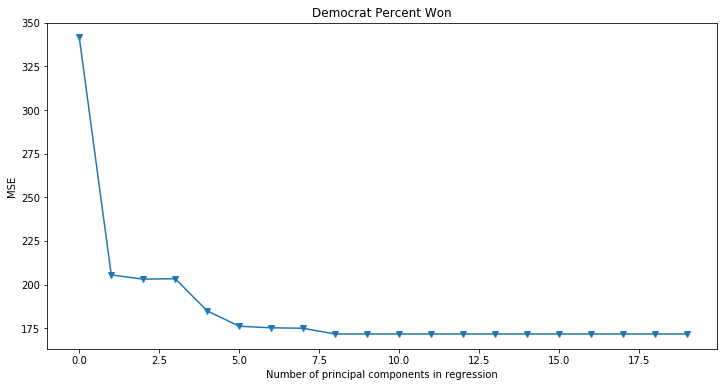

In [268]:
# 10-fold CV, with shuffle
kf_10 = KFold( n_splits=10, shuffle=True, random_state=1)

mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    score = -1*cross_val_score(regr, X_reduced_train2[:,:i], y_train.ravel(), cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Democrat Percent Won')
plt.xlim(xmin=-1);

It appears from this that 5 principal components will be small enough to reduce the MSE considerably without increasing the complexity by adding further components.

In [272]:
X_reduced_test2 = pca.transform(scale(X_test))[:,:5]

# Train regression model on training data 
regr = LinearRegression()
regr.fit(X_reduced_train2[:,:5], y_train)

# Prediction with test data
pred = regr.predict(X_reduced_test2)
mean_squared_error(y_test, pred)

186.06457517184214

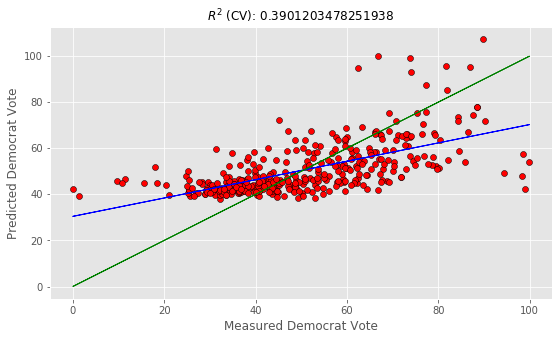

In [274]:
predicted, r2r, r2cv, mser, mscv = pcr(X_reduced_test2, y_test, pc=5)

# Regression plot
z = np.polyfit(y_test, predicted, 1)

with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y_test, predicted, c='red', edgecolors='k')
    ax.plot(y_test, z[1]+z[0]*y_test, c='blue', linewidth=1)
    ax.plot(y_test, y_test, color='green', linewidth=1)

plt.title('$R^{2}$ (CV): '+str(r2cv))
plt.xlabel('Measured Democrat Vote')
plt.ylabel('Predicted Democrat Vote')
plt.show()